# Time Series Prediction of AAPL Stock Price using ARIMA models & LSTM Recurrent Neural Networks (RNN)

# Introduction

## Dataset

Historical data of AAPL weekly stock prices from the first week of January 2013 to the last week of December 2017 with 261 observations is extracted from Yahoo Finance (https://finance.yahoo.com). The dataset contains the open, high, low, close and adjusted close prices and trading volumes of AAPL stock on every Monday throughout these past five years. To achieve consistency, the close prices are used as a general measure of stock price over this period of time.

## Data Exploration

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [23]:
# fix random seed for reproducibility
numpy.random.seed(7)

In [38]:
# load the dataset
df = pd.read_csv('AAPL.csv')
df.head(5)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2013-01-01,79.117142,79.285713,73.599998,74.842857,53.945232,497993300
1,2013-01-08,75.601425,75.984283,71.215714,71.678574,51.664482,638043000
2,2013-01-15,71.185715,72.964287,69.054283,71.428574,51.484295,623544600
3,2013-01-22,72.080002,73.570000,62.142857,64.261429,46.318352,1194363100
4,2013-01-29,65.500000,66.085716,63.142857,63.188572,45.545059,581062300


In [66]:
df.tail(5)

,Date,Open,High,Low,Close,Adj Close,Volume
256,2017-11-28,174.300003,174.869995,167.160004,169.800003,169.110519,181924100
257,2017-12-05,169.059998,172.889999,166.460007,172.669998,171.968857,140212500
258,2017-12-12,172.149994,177.199997,171.460007,176.419998,175.703629,133294500
259,2017-12-19,175.029999,176.020004,173.250000,175.009995,174.299362,88211300
260,2017-12-26,170.800003,171.850006,169.220001,169.229996,168.542831,97163800


In [39]:
df.index

RangeIndex(start=0, stop=261, step=1)

In [40]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,261.000000,261.000000,261.000000,261.000000,261.000000,2.610000e+02
mean,106.944450,109.291089,104.461910,107.208336,100.835390,2.723127e+08
std,29.618142,29.984740,29.325753,29.877551,33.598393,1.628530e+08
min,57.712856,58.895714,55.014286,56.952858,42.785866,8.003360e+07
25%,79.401428,81.567146,77.202858,79.642860,69.618690,1.521261e+08
50%,107.510002,110.230003,105.199997,107.330002,102.859612,2.302327e+08
75%,126.040001,128.119995,123.099998,126.370003,119.757301,3.481331e+08
max,175.029999,177.199997,173.250000,176.419998,175.703629,1.194363e+09


In [88]:
import datetime
# d - day of the month (01 to 31)
# b - abbreviated month name
# y - year without a century (range 00 to 99)
start = datetime.datetime.strptime("1 Jan 13", "%d %b %y")
daterange = pd.date_range(start, periods=261, freq='7d')  # frequency: weekly
print (type(df))
df2 = df['Close']
print (type(df2))
df2.index = pd.Index(daterange)  
# the index daterange is still necessary, otherwise the df2 won't be series format
df2.head(5)

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>


2013-01-01    74.842857
2013-01-08    71.678574
2013-01-15    71.428574
2013-01-22    64.261429
2013-01-29    63.188572
Freq: 7D, Name: Close, dtype: float64

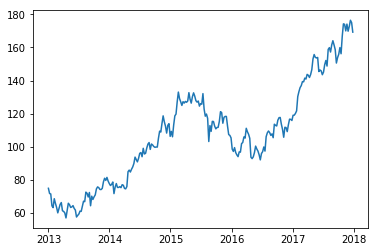

In [89]:
fig, ax = plt.subplots()
ax.plot(daterange, df2)

This plot shows that the close price of AAPL increases in general over the past five years. The variance of the stock price seems to increase slightly with time. These observations imply that a log or square-root transformation of the raw data might be appropriate in order to stabilize variance.

## Testing Stationarity - Unit Root Tests

To implement the ARIMA model for time-series analysis, the data needs to be stationary (no obvious trendence and period). If it is non-stationary, then we need to difference the data.
We use the most popular unit root test, the Augmentd Dickey-Fuller (ADF) test. The python library can be found in http://statsmodels.sourceforge.net/devel/generated/statsmodels.tsa.stattools.adfuller.html. If the p value is greater than 5%, we accept the null hypothesis and conclude that the time series has a unit root. In this case, we should first difference the series before proceeding with analysis. **If p-value of ADF test is < 5%, then the series is stationary.**

/Users/iris/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=4,center=False).mean()
  
/Users/iris/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=4,center=False).std()
  import sys


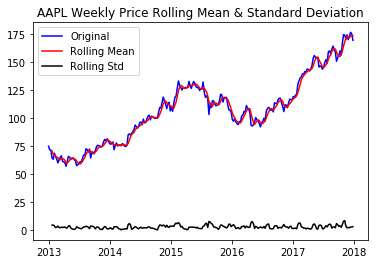

Results of Dickey-Fuller Test:
Test Statistic                  -0.176932
p-value                          0.941216
# Lags Used                      0.000000
Number of Observations Used    260.000000
Critical Value (1%)             -3.455754
Critical Value (5%)             -2.872721
Critical Value (10%)            -2.572728
dtype: float64


In [90]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    # note that timeseries needs to be class 'pandas.core.series.Series'
    # determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=4)
    rolstd  = pd.rolling_std(timeseries, window=4)
    
    # rolling_mean = moving ave, window=12 means every 12 months an avg,
    # so rolmean is "rolmean[0:12]=0, rolmean[12]=np.mean(timeseries[0:12])"
    # rolmean[13]=np.mean(timeseries[1:13])"
    
    fig = plt.subplots()
    
    original = plt.plot(daterange, timeseries, color='blue',label='Original')
    mean =     plt.plot(daterange, rolmean, color='red', label='Rolling Mean')
    std =      plt.plot(daterange, rolstd, color='black', label='Rolling Std')
    
    plt.legend(loc='best')
    plt.title('AAPL Weekly Price Rolling Mean & Standard Deviation')
    plt.show()
    
    # -------------------------------------------------------------
    # Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC') # for testing stationarity, reject the hypothesis if stationary
    #
    # the null hypothesis is "data are non-stationary", 
    # if p-value > critical value, we cannot reject the null hypothesis => non-stationary 
    # if p-value < critical value, we can reject the hypothesis => stationary 
    # if t-stat is comparable to 10% ceritical value, you cannot reject, if t-test small you can reject
    # note negative counts, the ideal case of the value is minus infinity
    # http://statsmodels.sourceforge.net/devel/generated/statsmodels.tsa.stattools.adfuller.html
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','# Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    
# Apply test to our time series:
test_stationarity(df2)

Since the p-value is greater than the threshold (0.941216 > 0.05), we cannnot reject the null hypothesis. Thus, the data is non-stationary. We need to do some transformation such as taking log function or differencing the data, to make the data stationary.

## Transformation of the Dataset

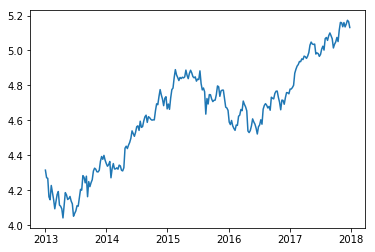

In [91]:
ts_log = np.log(df2)
fig = plt.subplots()
plt.plot(daterange,ts_log)

After logging the data, we further take moving mean with 4 weeks as the window.

2013-01-01    4.315391
2013-01-08    4.272192
2013-01-15    4.268698
2013-01-22    4.162960
2013-01-29    4.146123
Freq: 7D, Name: Close, dtype: float64 <class 'pandas.core.series.Series'>
2013-01-01         NaN
2013-01-08         NaN
2013-01-15         NaN
2013-01-22    4.254810
2013-01-29    4.212493
Freq: 7D, Name: Close, dtype: float64


/Users/iris/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=4,center=False).mean()
  


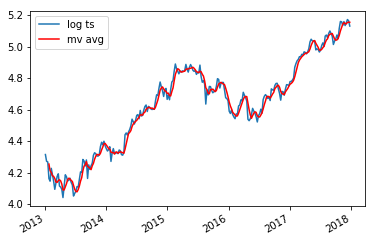

In [57]:
# Now compute the moving average
moving_avg = pd.rolling_mean(ts_log,4)  # moving mean, window = 4, every 4 weeks do averge.
print (ts_log.head(), type(ts_log))
print (moving_avg.head())
plt.plot(daterange, ts_log, label='log ts')
moving_avg.plot(color='red',label='mv avg')
plt.legend(loc='best')

Next we do first-order differencing the data:

In [58]:
# difference this from the log time series:
ts_log_moving_avg_diff = ts_log - moving_avg
ts_log_moving_avg_diff.head()

2013-01-01        NaN
2013-01-08        NaN
2013-01-15        NaN
2013-01-22   -0.09185
2013-01-29   -0.06637
Freq: 7D, Name: Close, dtype: float64

Now, let us drop off "NAN" in the data to make sure the data is clean, and examine again if the differenced log data is stationary:

/Users/iris/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=4,center=False).mean()
  
/Users/iris/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=4,center=False).std()
  import sys


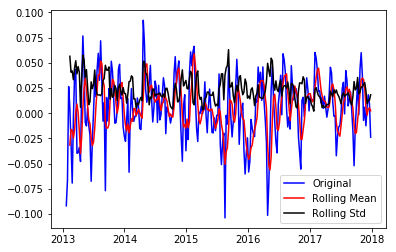

Results of Dickey-Fuller Test:
Test Statistic                -8.473574e+00
p-value                        1.455562e-13
# Lags Used                    2.000000e+00
Number of Observations Used    2.550000e+02
Critical Value (1%)           -3.456257e+00
Critical Value (5%)           -2.872942e+00
Critical Value (10%)          -2.572846e+00
dtype: float64


In [59]:
# Drop the NANs and check stationarity:
ts_log_moving_avg_diff.dropna(inplace=True)
daterange = daterange[3:]
test_stationarity(ts_log_moving_avg_diff)

After taking log transformation on the data and do first-order differencing, the data now becomes stationary, as shown above. The ADF test shows that the p-value is << 0.05, so we can reject the null-hypothesis: the data is non-stationary. We can implement the ARIMA models to the transformed data and make prediction.

# ACF and PACF

There are three main controllable parameters in the ARIMA models, $(p,d,q)$; $p: $ order of autoregression part meaning past values of variable, $d: $ order of difference and $q: $ order of moving average meaning past forecast errors. An $(p,d,q)$ ARIMA model is written as
$y(t) = c + \phi(1)y(t-1) +.. +\phi(p)y(t-p) + \theta(1)\epsilon(t-1) + .. +\theta(q)\epsilon(t-q) + \epsilon(t)$ |<- autoregression ->| |<- moving average ->|
Here $y(t)$ can be the variable with $d$-th order difference. If $d=1$, $y(t) = y'(t) = y(t)-y(t-1).$
Next we can examine ACF and PACF (parital ACF) to have good initial guess on $p$ and $q$. The library can be found in http://statsmodels.sourceforge.net/devel/generated/statsmodels.tsa.stattools.acf.html.

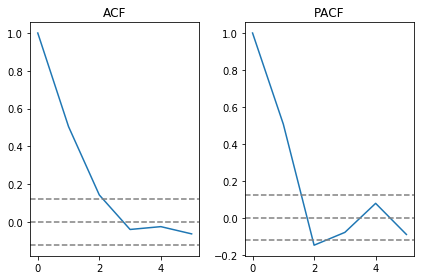

In [72]:
#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf
lag_acf = acf(ts_log_moving_avg_diff, nlags=5)
lag_pacf = pacf(ts_log_moving_avg_diff, nlags=5, method='ols')

#print (lag_acf, lag_pacf)

#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_moving_avg_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_moving_avg_diff)),linestyle='--',color='gray')
plt.title('ACF')

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_moving_avg_diff)),linestyle='--',color='gray')  ##1.96 95% confidence interval
plt.axhline(y=1.96/np.sqrt(len(ts_log_moving_avg_diff)),linestyle='--',color='gray')
plt.title('PACF')
plt.tight_layout()
## the figures below suggest p=1 from acf, q=1, or 2 from pacf, for (p,d,q) ARIMA models
## for acf, the 0-crossing point is at 1, so p=1; and for pacf q = 1

## Model Fitting & Diagnostics

### TSA.ARIMA_MODEL fitting

In fitting ARIMA model, the rule of thumb is to select models with as few parameters as possible, yet still be capable of explaining the series 1. The more parameters the greater noise that can be introduced into the model and hence standard deviation. Therefore, the benchmark values for $p$ and $q$ are chosen up to 2 since the higher $p$ and $q$, the less stable the model is, reflecting the less accurate forecast. According to this method, the model with lowest AICc will be selected.

Now if we have $(p,d,q)$, how can we find the coefficients $\phi$ and $\theta$? Next we are going to implement the library tsa.arima_model http://statsmodels.sourceforge.net/0.6.0/generated/statsmodels.tsa.arima_model.ARIMA.html to fit the equation:
$$\phi(L)(y_{t} - X_{t}\beta) = \theta(L)\epsilon_{t},$$
where $L$ is the likelihood of the data. It returns the "statsmodels.tsa.arima.ARIMAResults" class and has the fit.aic feature. We also use the Scipy library to brute force $(p,d,q) = (0-3,0-3,0-3)$ in increment of 1. The "fit.aic" gives Akaike's information criterion (AIC):
$$AIC = -2log(L) + 2(p+q+k+1),$$
So AIC value is good as lower as possible, meaning maximum likelihood is obtained. Then we can use values of $(p,d,q)$ and $(\phi,\theta)$ to build our ARIMA model.

In [82]:
from statsmodels.tsa.arima_model import ARMA, ARIMA
def objfunc(order):    
    try:
        fit = sm.tsa.ARIMA(ts_log_moving_avg_diff,order).fit()
        # fit = sm.tsa.ARIMA(ts_log,order).fit()
        print(fit.aic)
        print(order)
        return fit.aic
        # akaike information criterion, how much formation loss for a given model, fit.aic as small as much
        # nagtive is good, [000] is always a trivial solution
    except:
        print('No good!')
        print(order)

        
from scipy.optimize import brute
import statsmodels.api as sm
grid = (slice(0,3,1), slice(0,3,1), slice(0,3,1)) 
# grid=(p,d,q), p,d,q = 0-3
# here is the loop (0,3,1) 0: start, 3: end, 1:increment
brute(objfunc, grid, finish=None) # scipy function for just doing loop

-1044.3629815070349
[0 0 0]
-1044.3629815070349
[0 0 0]
-1113.0071487571627
[0 0 1]
-1129.8762029892418
[0 0 2]
-1052.3891981397219
[0 1 0]
-1057.8302323387593
[0 1 1]
-1101.0166082200672
[0 1 2]
-840.1435850948667
[0 2 0]
-1039.9248632985289
[0 2 1]
-1044.8296897189662
[0 2 2]
-1121.7023908983206
[1 0 0]
-1123.8252761650288
[1 0 1]
-1128.3470226438321
[1 0 2]
-1054.548070779099
[1 1 0]
-1110.5996372203576
[1 1 1]


/Users/iris/anaconda2/envs/py36/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:650: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/Users/iris/anaconda2/envs/py36/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:650: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/Users/iris/anaconda2/envs/py36/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:651: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/Users/iris/anaconda2/envs/py36/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:651: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/Users/iris/anaconda2/envs/py36/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:606: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/
/Users/iris/a

No good!
[1 1 2]
-909.684222602752
[1 2 0]
No good!
[1 2 1]
No good!
[1 2 2]
-1125.5839432888993
[2 0 0]
-1124.581908505304
[2 0 1]
-1126.4420394222302
[2 0 2]
-1060.511338739449
[2 1 0]
-1114.1819901691115
[2 1 1]
-1106.7992853021556
[2 1 2]
-929.3679943026027
[2 2 0]
No good!
[2 2 1]
No good!
[2 2 2]


array([1., 1., 2.])

The above parameter scan tells us that $(p,d,q) = [0,0,2],$ $[1,0,2]$ and $[2,0,2]$ provided lower AIC than others. Next we further check the convergence:

In [81]:
# double check convergence [0 0 2], [1 0 2], [2 0 2] = (p,d,q)
fit = sm.tsa.ARIMA(ts_log_moving_avg_diff,(0,0,2)).fit()
print(fit.aic)
fit = sm.tsa.ARIMA(ts_log_moving_avg_diff,(1,0,2)).fit()
print(fit.aic)
fit = sm.tsa.ARIMA(ts_log_moving_avg_diff,(2,0,2)).fit()
print(fit.aic)

-1129.8762029892418
-1128.3470226438321
-1126.4420394222302


From these double check, we can infer the best convergent answers is given by $(p,d,q) = [0,0,2].$ How is our model with the parameter selection? We can visualize the fitting result:

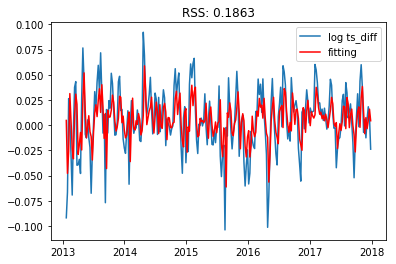

In [83]:
model = sm.tsa.ARIMA(ts_log_moving_avg_diff, order=(0, 0, 2))  
results_ARIMA = model.fit(disp=-1) # disp plot parameters

fig = plt.subplots()
plt.plot(daterange, ts_log_moving_avg_diff, label='log ts_diff')
plt.plot(daterange, results_ARIMA.fittedvalues, color='red', label='fitting')
ParRSS = results_ARIMA.fittedvalues-ts_log_moving_avg_diff
ParRSS.dropna(inplace=True)
plt.title('RSS: %.4f'% sum((ParRSS)**2))
plt.legend(loc='best')

The blue line denotes the differenced log data. The red line is given by the fitting results using the Python library with $(p,d,q) = [0,0,2].$
Then we can use the $(1,0,3)$ ARIMA model to forecast the future:

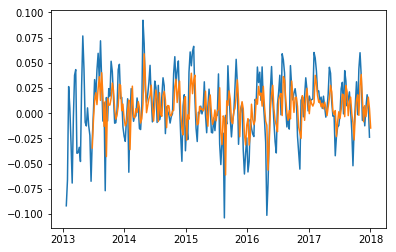

In [92]:
plt.subplots()
plt.plot(ts_log_moving_avg_diff)
plt.plot(sm.tsa.ARIMA(ts_log_moving_avg_diff, (0,0,2)).fit(disp=-1).predict('2013-06-25', '2018'))

The blue line is the differenced log data. The green line is the $(0,0,2)$ ARIMA model fitting result. However, note that the data shown above is the differenced log data. We still need to transform back to the original data, i.e. removing log and without difference:

In [97]:
predictions_ARIMA_diff = sm.tsa.ARIMA(ts_log_moving_avg_diff, (0,0,2)).fit(disp=-1).predict('2013-06-25', '2017')

2017-04-04    143.856987
2017-04-11    143.161487
2017-04-18    142.729901
2017-04-25    144.642054
2017-05-02    148.378332
2017-05-09    153.834080
2017-05-16    155.532211
2017-05-23    154.394876
2017-05-30    154.094392
2017-06-06    152.078902
dtype: float64


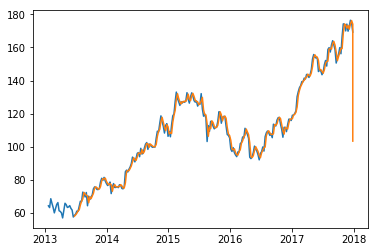

In [98]:
SplitPredict = predictions_ARIMA_diff['2017-12-26':]
InRangePredict = predictions_ARIMA_diff[:'2017-12-26']
InRangeTrans = InRangePredict + moving_avg
MovingToAdd = moving_avg.mean()
AverageDF = pd.Series([MovingToAdd for x in range(len(SplitPredict.index))], index=SplitPredict.index)
PredictedNew = SplitPredict + AverageDF
FullPredict = pd.Series.append(InRangeTrans,PredictedNew)
compare = ts_log_moving_avg_diff + moving_avg
compare = np.exp(compare)
FullPredict = np.exp(FullPredict)
subplots()
plt.plot(compare)
plt.plot(FullPredict)
print (FullPredict[len(FullPredict)-40:len(FullPredict)-30])

# LSTM Recurrent Neural Networks (RNN)

In [51]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [33]:
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

174 87


In [34]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return numpy.array(dataX), numpy.array(dataY)

In [35]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [36]:
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

Epoch 1/100
 - 1s - loss: 0.0965
Epoch 2/100
 - 0s - loss: 0.0525
Epoch 3/100
 - 0s - loss: 0.0299
Epoch 4/100
 - 0s - loss: 0.0218
Epoch 5/100
 - 0s - loss: 0.0192
Epoch 6/100
 - 0s - loss: 0.0174
Epoch 7/100
 - 0s - loss: 0.0157
Epoch 8/100
 - 0s - loss: 0.0139
Epoch 9/100
 - 0s - loss: 0.0121
Epoch 10/100
 - 0s - loss: 0.0104
Epoch 11/100
 - 0s - loss: 0.0088
Epoch 12/100
 - 0s - loss: 0.0073
Epoch 13/100
 - 0s - loss: 0.0058
Epoch 14/100
 - 0s - loss: 0.0046
Epoch 15/100
 - 0s - loss: 0.0037
Epoch 16/100
 - 0s - loss: 0.0029
Epoch 17/100
 - 0s - loss: 0.0022
Epoch 18/100
 - 0s - loss: 0.0018
Epoch 19/100
 - 0s - loss: 0.0015
Epoch 20/100
 - 0s - loss: 0.0013
Epoch 21/100
 - 0s - loss: 0.0012
Epoch 22/100
 - 0s - loss: 0.0011
Epoch 23/100
 - 0s - loss: 0.0010
Epoch 24/100
 - 0s - loss: 0.0010
Epoch 25/100
 - 0s - loss: 9.7068e-04
Epoch 26/100
 - 0s - loss: 9.6034e-04
Epoch 27/100
 - 0s - loss: 9.8711e-04
Epoch 28/100
 - 0s - loss: 9.7062e-04
Epoch 29/100
 - 0s - loss: 9.7075e-04
Epo

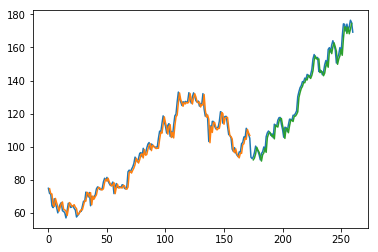

In [10]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(5, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=3, verbose=2)
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()